In [180]:
import praw
import pandas as pd
import re
import string
import nltk
from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
%matplotlib inline

In [181]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [184]:
def get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd):
    '''
    returns subreddit object with top 1000 subreddit posts
    
    '''

    with open(oa_script) as f:
    
        script = f.read().strip()

    with open(oa_secret) as f:
    
        secret = f.read().strip()

    with open(pwd) as f:
    
        pw = f.read().strip()
    
# get reddit object
    
    reddit = praw.Reddit(client_id=script,
                        client_secret=secret,
                        user_agent=app_name,
                        username='neurodivergent_ai',
                        password=pw)

    # get subreddit

    subreddit = reddit.subreddit(subreddit_name)

    # get top posts

    top = subreddit.top(limit=1000)

    for post in subreddit.top(limit=5):
    
        print(post.title, '\n')
        
    return top


In [185]:
#get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd):


donald_subreddit = get_subreddit('The_Donald', 'get_corpora', 
                                     'reddit_oa_script.txt', 'reddit_oa_secret.txt',
                                    'reddit_id.txt')

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



In [175]:
# iterate through reddit object, build dictionary, return dataframes
# return titles&posts df, plus whole df

def make_subreddit_df(subreddit_object):
    '''
    takes subreddit api object,
    returns as dataframe:
    
    * entire subreddit, all columns
    
    '''
    
    columns_dict = {'title': [],
                   'url': [],
                   'date': [],
                   'score': [],
                   'n_comments': [],
                   'body': []}
    
    # build dictionary
    
    for post in subreddit_object:
        
        columns_dict['title'].append(post.title)
        
        columns_dict['url'].append(post.url)
        
        columns_dict['date'].append(post.created)
        
        columns_dict['score'].append(post.score)
        
        columns_dict['n_comments'].append(post.num_comments)
        
        columns_dict['body'].append(post.selftext)
    
    # convert to dataframe
    
    subreddit_df = pd.DataFrame(columns_dict)
    
    # split off text for df
    
    #corpus_df = subreddit_df['title'] + subreddit_df['body']
    
    #titles = subreddit_df['title']
    #txt_bodies = subreddit_df['body']
    #corpus_ls = titles + txt_bodies
    
    return subreddit_df
        

In [186]:
donald_subreddit_df = make_subreddit_df(donald_subreddit)

In [187]:
donald_subreddit_df.head()

,title,url,date,score,n_comments,body
0,DONALD J. TRUMP DECLARED THE WINNER!,https://www.reddit.com/r/The_Donald/comments/5...,1.478706e+09,66710,12087,#Meme Magic is REAL.\n\n#Donald J. Trump is th...
1,I’m Donald J. Trump and I'm Your Next Presiden...,https://www.reddit.com/r/The_Donald/comments/4...,1.469687e+09,42126,20790,Hello The_Donald readers and the entire Reddit...
2,The New Algorithm Was Designed To Keep Preside...,https://i.sli.mg/gu0oHA.png,1.481092e+09,40978,832,
3,CNN will soon be #1...when searching for the t...,https://i.redd.it/7jeyhzgku65y.png,1.482472e+09,37279,724,
4,ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A....,https://www.reddit.com/r/The_Donald/comments/5...,1.478702e+09,36614,1685,Now that we have proven our commitment to the ...


In [190]:
# text cleaning: 2 different versions
# light clean for model training, heavy clean for vocab work

def light_clean(doc):
    '''
    lightly cleans input doc for
    word embedding training:
    
    * tokenizes
    * lowercase
    * removes punctuation & non-alpha characters
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # punctuation list
    
    punctuation = string.punctuation
    
    # set up regex filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # alpha tokens only
    
    alpha_tokens = [t for t in no_punct_tokens if t.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    return lower_tokens

def super_clean(doc):
    '''
    cleans a single input document.
    applies more processing than
    light_clean():
    
    * tokenizes
    * lowercase
    * removes punctuation & numbers
    * removes stopwords
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # grab punctuation list
    
    punctuation = string.punctuation
    
    # setup re filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # take out numbers & any other non-alpha characters
    
    alpha_tokens = [i for i in no_punct_tokens if i.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    # get stop words
    
    stop_words = set(stopwords.words('english'))
    
    # filter out stopwords
    
    go_tokens = [t for t in lower_tokens if not t in stop_words]
    
    # remove very short tokens
    
    clean_tokens = [word for word in go_tokens if len(word) > 1]
    
    return clean_tokens

In [199]:

def clean_all_docs(docs):
    
    clean_docs = []
    
    for doc in docs:
        
        doc = super_clean(doc)
        
        if doc:
            
            clean_docs.append(doc)
        
       
    # get vocabulary
    '''
    
    for doc in light_clean_docs:
        
        for word in doc:
            
            light_clean_vocab.append(word)
            
    for doc in super_clean_docs:
        
        for word in doc:
            
            super_clean_vocab.append(word)
    
    # get word counts
    
    light_clean_counts = Counter(light_clean_vocab)
    
    super_clean_counts = Counter(super_clean_vocab)
    
    # get light clean text vocab to dataframe
    
    lc_vocab_df = pd.DataFrame.from_dict(light_clean_counts, orient='index')
    
    # sort by most frequent words
    
    lc_vocab_df = lc_vocab_df.sort_values(by=[0], ascending=False)
    
    # index
    
    light_clean_vocab = lc_vocab_df.reset_index()
    
    # get super clean text vocab
    
    sc_vocab_df = pd.DataFrame.from_dict(super_clean_counts, orient='index')
    
    sc_vocab_df = sc_vocab_df.sort_values(by=0, ascending=False)
    
    super_clean_vocab = sc_vocab_df.reset_index()
    
    '''
     
            
    return clean_docs


In [202]:
titles_df = donald_subreddit_df['title']

posts_df = donald_subreddit_df['body']

donald_clean_titles = clean_all_docs(titles_df)

donald_clean_posts = clean_all_docs(posts_df)

In [203]:
print(donald_clean_titles[4])
print(donald_clean_posts[2])

['celebrities', 'vowed', 'leave', 'usa', 'trump', 'wins', 'demand', 'follow']
['proven', 'commitment', 'cause', 'voiced', 'acted', 'patriotism', 'odds', 'constant', 'criticism', 'world', 'us', 'call', 'elitist', 'hollywood', 'celebrities', 'vowed', 'betray', 'country', 'leave', 'abandon', 'shun', 'spent', 'careers', 'milking', 'posh', 'lifestyles', 'ask', 'nay', 'demand', 'follow', 'claims', 'leave', 'country', 'americans', 'spoken', 'brushed', 'us', 'movement', 'somehow', 'us', 'forgetting', 'us', 'made', 'fuck', 'think', 'good', 'us', 'well', 'good', 'follow', 'vapid', 'empty', 'threat', 'mistakenly', 'pridefully', 'consider', 'get', 'fuck', 'fame', 'celebrity', 'status', 'despicable', 'shall', 'say', 'deplorable', 'better', 'us', 'important', 'us', 'would', 'nothing', 'without', 'us', 'dare', 'pretend', 'us', 'list', 'demand', 'leave', 'asap', 'amy', 'unfunny', 'schumer', 'lena', 'dunham', 'barbra', 'streisand', 'bryan', 'cranston', 'miley', 'cyrus', 'amy', 'schumer', 'jon', 'stewar

In [207]:
# TODO:
# find a way to automate combining clean
# titles & texts (lists) into doc

donald_clean_corpus = donald_clean_titles + donald_clean_posts

In [208]:
def train_w2v_model(docs):
    '''
    trains word2vec model on input set of docs.
    fits PCA projection to 2d space.
    prints 2d visualization of words in vector space.
    returns trained model.
    
    '''
    
    # train w2v model 
    
    w2v_model = Word2Vec(docs, min_count=1)
    
    # get vocab
    
    vector_vocab = w2v_model[w2v_model.wv.vocab]
    
    # fit PCA model / 2d projection
    
    pca_model = PCA(n_components=2)
    
    pca_projection = pca_model.fit_transform(vector_vocab)
    
    # plot
    
    pyplot.scatter(pca_projection[:, 0], pca_projection[:, 1])
    
    # plot with words
    
    vocab_list = list(w2v_model.wv.vocab)
    
    for i, word in enumerate(vocab_list):
        
        pyplot.annotate(word, xy=(pca_projection[i, 0], pca_projection[i, 1]))  
    
    return w2v_model
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


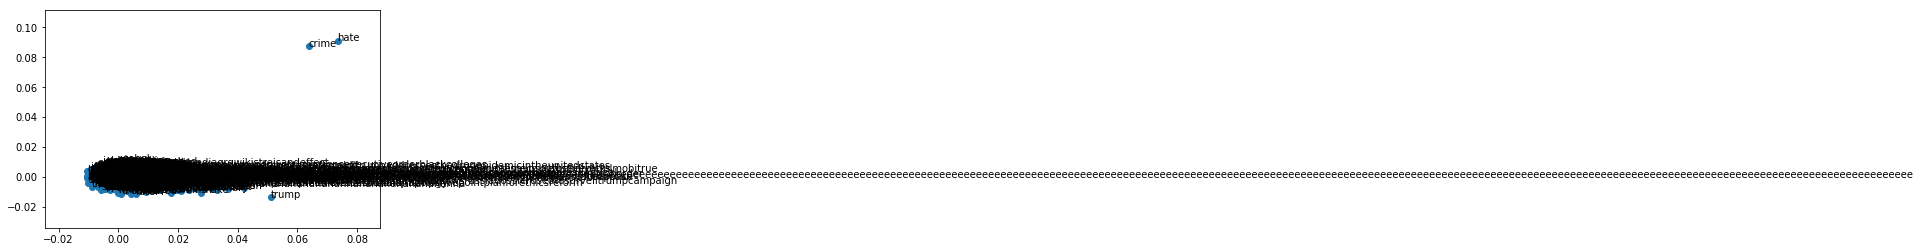

In [209]:
donald_model = train_w2v_model(donald_clean_corpus)

In [212]:
def get_cos_sim(model, word_1, word_2):
    
    return model.wv.similarity(word_1, word_2)


def compare_cos_sim(model, word_list, comp_word):
    
    cos_sim_list = []
    
    for word in word_list:
        
        cos_sim = get_cos_sim(model, word, comp_word)
        
        in_list = []
        
        in_list.append(comp_word)
        
        in_list.append(word)
        
        in_list.append(cos_sim)
        
        cos_sim_list.append(in_list)
    
    return cos_sim_list    
            

In [213]:
# make contrived list

list_A = ['president', 'qualified', 'girls', 'rights', 'abortion', 'children']

word_1 = 'women'

word_2 = 'men'


In [214]:
# compare_cos_sim(model, word_list, comp_word)

cos_sims_list_1 = compare_cos_sim(donald_model, list_A, word_1)

cos_sims_list_2 = compare_cos_sim(donald_model, list_A, word_2)

In [215]:
print(cos_sims_list_1, '\n')
print(cos_sims_list_2)

[['women', 'president', 0.27411670437195534], ['women', 'qualified', 0.21916707785291678], ['women', 'girls', -0.07361601003673725], ['women', 'rights', 0.10200344319404742], ['women', 'abortion', -0.01916155517427852], ['women', 'children', 0.1024316077309901]] 

[['men', 'president', 0.1374632015535055], ['men', 'qualified', 0.22249292040195082], ['men', 'girls', -0.016517068115383577], ['men', 'rights', 0.06873884769749228], ['men', 'abortion', -0.12139775033484614], ['men', 'children', -0.012414883985308336]]


In [157]:
# functions to autogenerate lists
# based on word frequency

def get_top_50(df):
    
    '''
    grabs top 50 vocab words from 
    dataframe. returns as list.
    
    NOTE: works best when
    stopwords are removed.
    
    use here with super clean vocabs.
    
    '''
    
    top_50_list = list(df[:50]['index'])
    
    return top_50_list

def get_bottom_50(df):
    '''
    same as get_top_50()
    except it gets the bottom 50
    
    '''
    
    bottom_50_list = list(df[-50:]['index'])
    
    return bottom_50_list


In [158]:
feminism_top_50 = get_top_50(feminism_sc_vocab)

In [159]:
feminism_bottom_50 = get_bottom_50(feminism_sc_vocab)

In [160]:
def comp_cos_sim_lists(model, list_1, list_2):
    
    cos_sim_list = []
    
    for word in list_1:
        
        if word not in list_2:
            
            sim_line = compare_cos_sim(model, list_2, word)
            
            cos_sim_list.append(sim_line)
    
    return cos_sim_list
            

In [161]:
cos_sim_lists = comp_cos_sim_lists(feminism_model_lc, list_A, feminism_top_50)

print(cos_sim_lists)

[[['president', 'women', 0.9966836446172203], ['president', 'men', 0.9967631632765119], ['president', 'woman', 0.9967097281517575], ['president', 'rape', 0.996850530220292], ['president', 'sexual', 0.9966440427843102], ['president', 'feminist', 0.996555517946486], ['president', 'like', 0.9964598376114205], ['president', 'people', 0.9965444741746303], ['president', 'female', 0.9966883171528427], ['president', 'feminism', 0.996711287759589], ['president', 'man', 0.9967385432457078], ['president', 'male', 0.9965998316425457], ['president', 'first', 0.9968689370543296], ['president', 'time', 0.9966179679917831], ['president', 'one', 0.9969180600790768], ['president', 'get', 0.9966665087446138], ['president', 'im', 0.9964760698915813], ['president', 'sex', 0.996622090359969], ['president', 'dont', 0.9965399489493251], ['president', 'us', 0.9964862112153261], ['president', 'would', 0.9965217733623787], ['president', 'never', 0.9967235514448921], ['president', 'know', 0.9965464068492463], ['p

In [167]:
# gonna start off with just testing

def WEAT_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd):
    
    subreddit = get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd)
    
    subreddit, corpus = make_corpus(subreddit)
    
    # light_clean_docs, light_clean_vocab, super_clean_docs, super_clean_vocab
    
    lc_corpus, lc_vocab, sc_corpus, sc_vocab = clean_all_docs(corpus)
    
    # use both lightly & super cleaned corpora to train model
    
    lc_model = train_w2v_model(lc_corpus)
    
    sc_model = train_w2v_model(sc_corpus)
    
    #compare_cos_sim(model, word_list, comp_word):
    
    words = ['president', 'child', 'qualified', 'smart', 'good', 'evil']
    
    sim_list_man = compare_cos_sim(lc_model, words, 'man')
    
    sim_list_woman = compare_cos_sim(lc_model, words, 'woman')
    
    return lc_model, sim_list_man, sim_list_woman


DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


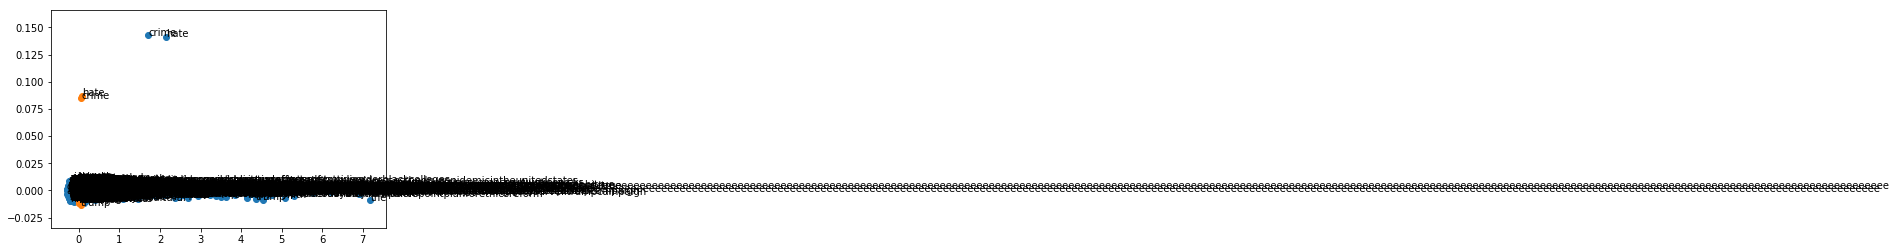

In [168]:
#WEAT_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd
'''
user_agent='get_corpora',
username='neurodivergent_ai',
password=pw)

'reddit_oa_script.txt'
'reddit_oa_secret.txt'
'reddit_id.txt'
'''

model1, man_list, woman_list = WEAT_pipeline('The_Donald', 'get_corpora', 
                                     'reddit_oa_script.txt', 'reddit_oa_secret.txt',
                                    'reddit_id.txt')

In [169]:
print(man_list, woman_list)

[['man', 'president', 0.9995972414660116], ['man', 'child', 0.9987432751457547], ['man', 'qualified', 0.8706532733826551], ['man', 'smart', 0.9958553614752533], ['man', 'good', 0.9993748855567396], ['man', 'evil', 0.9235109493410409]] [['woman', 'president', 0.9992906435242022], ['woman', 'child', 0.9984589154959734], ['woman', 'qualified', 0.8735135680076231], ['woman', 'smart', 0.995711994987023], ['woman', 'good', 0.9989793030762185], ['woman', 'evil', 0.9223876631610801]]


In [166]:
#get_cos_sim(model, word_1, word_2)

#compare_cos_sim(model, word_list, comp_word)

cos1 = get_cos_sim(model1, 'man', 'president')
cos2 = get_cos_sim(model1, 'woman', 'president')

print(cos1, cos2)

0.9995601548824246 0.9995024586723307
